**Melanoma Detection**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


**Import Libraries**

In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import json

**Import Libraries for Keras and Tensorflow**

In [ ]:
import tensorflow as tf
from keras import layers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.layers import  Dropout , BatchNormalization , Dense
from keras.optimizers import Adam
from keras.applications import ResNet50
from keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint
from sklearn.metrics import cohen_kappa_score, accuracy_score


**Take the data and Resize them to (224,224)**

In [ ]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpeg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/drive/MyDrive/CSE499/Dataset/train/benign',224))
malign_train = np.array(Dataset_loader('/content/drive/MyDrive/CSE499/Dataset/train/malignant',224))
benign_test = np.array(Dataset_loader('/content/drive/MyDrive/CSE499/Dataset/valid/benign',224))
malign_test = np.array(Dataset_loader('/content/drive/MyDrive/CSE499/Dataset/valid/malignant',224))

100%|██████████| 1500/1500 [09:37<00:00,  2.60it/s]


**Visualisation**

In [ ]:
print(f'Benign Train:',benign_train.shape)
print(f'Malignant Train',malign_train.shape)
print(f'Benign Test:',benign_test.shape)
print(f'Malignant Test',malign_test.shape)

Benign Train: (3500, 224, 224, 3)
Malignant Train (3496, 224, 224, 3)
Benign Test: (1500, 224, 224, 3)
Malignant Test (1500, 224, 224, 3)


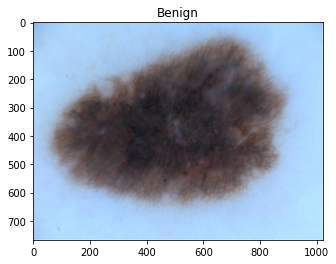

In [ ]:
im = cv2.imread('/content/drive/MyDrive/CSE499/Dataset/train/benign/ISIC_0000000.jpeg')
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.title('Benign')
plt.show()

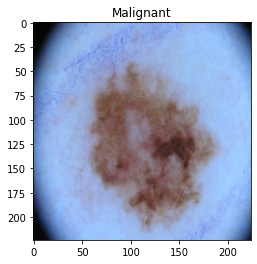

In [ ]:
im = cv2.imread('/content/drive/MyDrive/CSE499/Dataset/train/malignant/ISIC_0000002.jpeg')
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.title('Malignant')
plt.show()

**Create Label for each class 0 = Benign , 1 = malignant**

In [ ]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test)) 

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
print(f'X train shape:',X_train.shape)
print(f'X test shape:',X_test.shape)
print(f'Y train shape:',Y_train.shape)
print(f'Y test shape:',Y_test.shape)

X train shape: (6996, 224, 224, 3)
X test shape: (3000, 224, 224, 3)
Y train shape: (6996, 2)
Y test shape: (3000, 2)


**Split the Train and Valid**

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=10)

In [ ]:
print(f'x train shape:',x_train.shape)
print(f'x val shape:',x_val.shape)
print(f'y train shape:',y_train.shape)
print(f'y val shape:',y_val.shape)

x train shape: (5596, 224, 224, 3)
x val shape: (1400, 224, 224, 3)
y train shape: (5596, 2)
y val shape: (1400, 2)


**Let's display Some images**

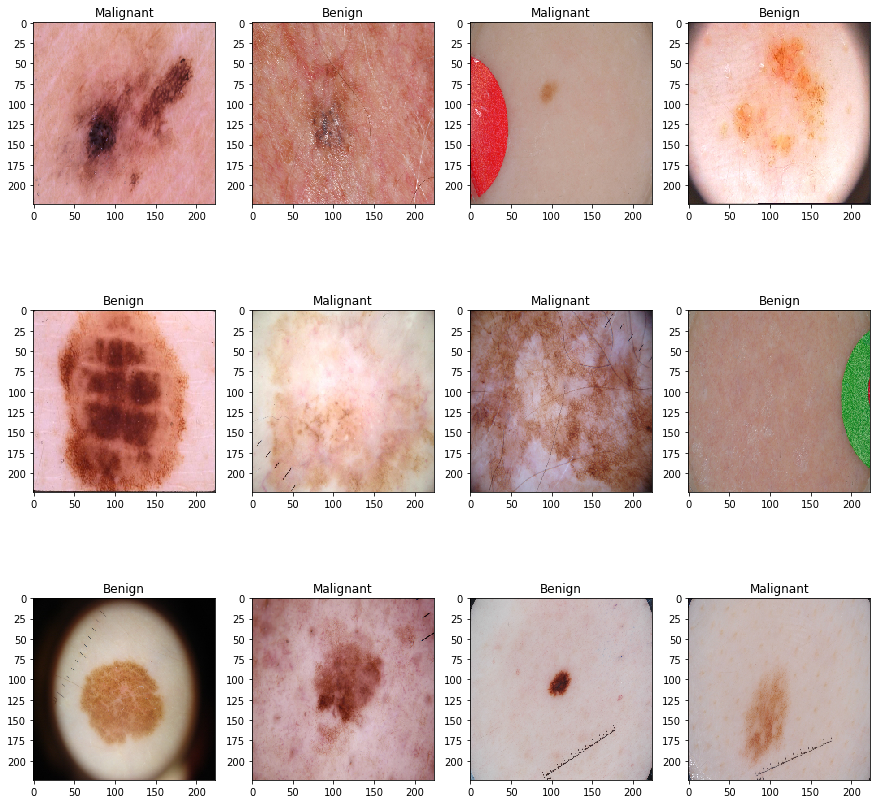

In [ ]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

**Data Generator**

https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c

https://keras.io/api/preprocessing/image/

In [ ]:
#using batch_size = 64
BATCH_SIZE = 64

train_generator = ImageDataGenerator(
        zoom_range=2, 
        rotation_range = 90,
        horizontal_flip=True, 
        vertical_flip=True, 
    )

**Model**

Used model is **ResNet50** : https://keras.io/api/applications/resnet/#resnet50-function

In [ ]:
def build_model(backbone , lr = 5e-4):
  model = Sequential()
  model.add(backbone)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dropout(0.5))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(2 , activation='softmax'))
  
  model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
  return model

In [ ]:
resnet = ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape =(224 , 224 , 3)
)
#call the model 
model = build_model(resnet , lr = 1e-4)
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,600,002
Trainable params: 23,542,786
Non-trainable params: 57,216
_________________________________________________________________
